In [ ]:
#Note
https://www.kaggle.com/code/harshraone/super-resolution-using-multi-scale-learning

In [12]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add ,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.8.2


In [ ]:
#Setup download dataset from kaggle to colab
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir /root/.kaggle

In [ ]:
!cp kaggle.json /root/.kaggle

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityachandrasekhar/image-super-resolution

 96% 289M/301M [00:04<00:00, 120MB/s] 
100% 301M/301M [00:04<00:00, 74.3MB/s]


In [ ]:
!unzip /content/image-super-resolution.zip

Archive:  /content/image-super-resolution.zip
  inflating: dataset/Raw Data/high_res/0.png  
  inflating: dataset/Raw Data/high_res/1.png  
  inflating: dataset/Raw Data/high_res/10.png  
  inflating: dataset/Raw Data/high_res/100.png  
  inflating: dataset/Raw Data/high_res/101.png  
  inflating: dataset/Raw Data/high_res/102.png  
  inflating: dataset/Raw Data/high_res/103.png  
  inflating: dataset/Raw Data/high_res/104.png  
  inflating: dataset/Raw Data/high_res/105.png  
  inflating: dataset/Raw Data/high_res/106.png  
  inflating: dataset/Raw Data/high_res/107.png  
  inflating: dataset/Raw Data/high_res/108.png  
  inflating: dataset/Raw Data/high_res/109.png  
  inflating: dataset/Raw Data/high_res/11.png  
  inflating: dataset/Raw Data/high_res/110.png  
  inflating: dataset/Raw Data/high_res/111.png  
  inflating: dataset/Raw Data/high_res/112.png  
  inflating: dataset/Raw Data/high_res/113.png  
  inflating: dataset/Raw Data/high_res/114.png  
  inflating: dataset/Raw Data

In [ ]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
#path = '../input/image-super-resolution/dataset/Raw Data/high_res'
path = '/content/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
#path = '../input/image-super-resolution/dataset/Raw Data/low_res'
path = '/content/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:02<00:00, 301.96it/s]


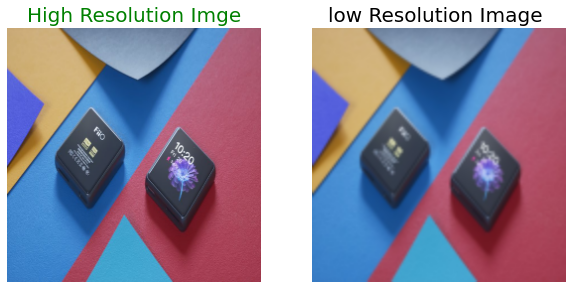

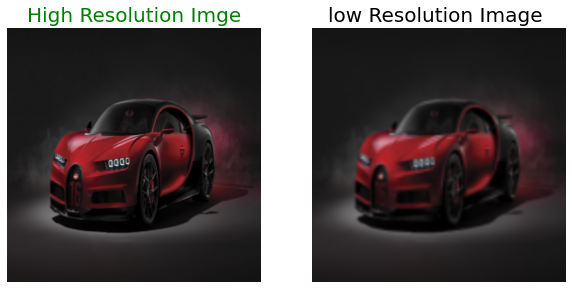

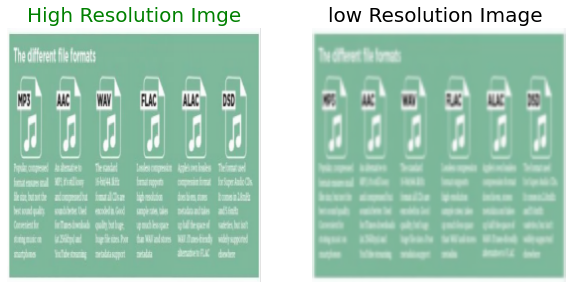

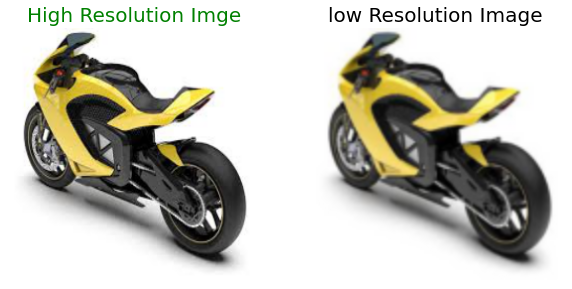

In [ ]:
for i in range(4):
    a = np.random.randint(0,100)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [ ]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [ ]:
print(type(test_low_image[0]))

<class 'numpy.ndarray'>


In [ ]:
Model Building

In [ ]:
input_shape =Input(shape=(256,256,3))
batch_size = 1
kernel_size = 3
dropout = 0.4
n_filters = 64

In [ ]:
def Upsample_block(x,ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                             

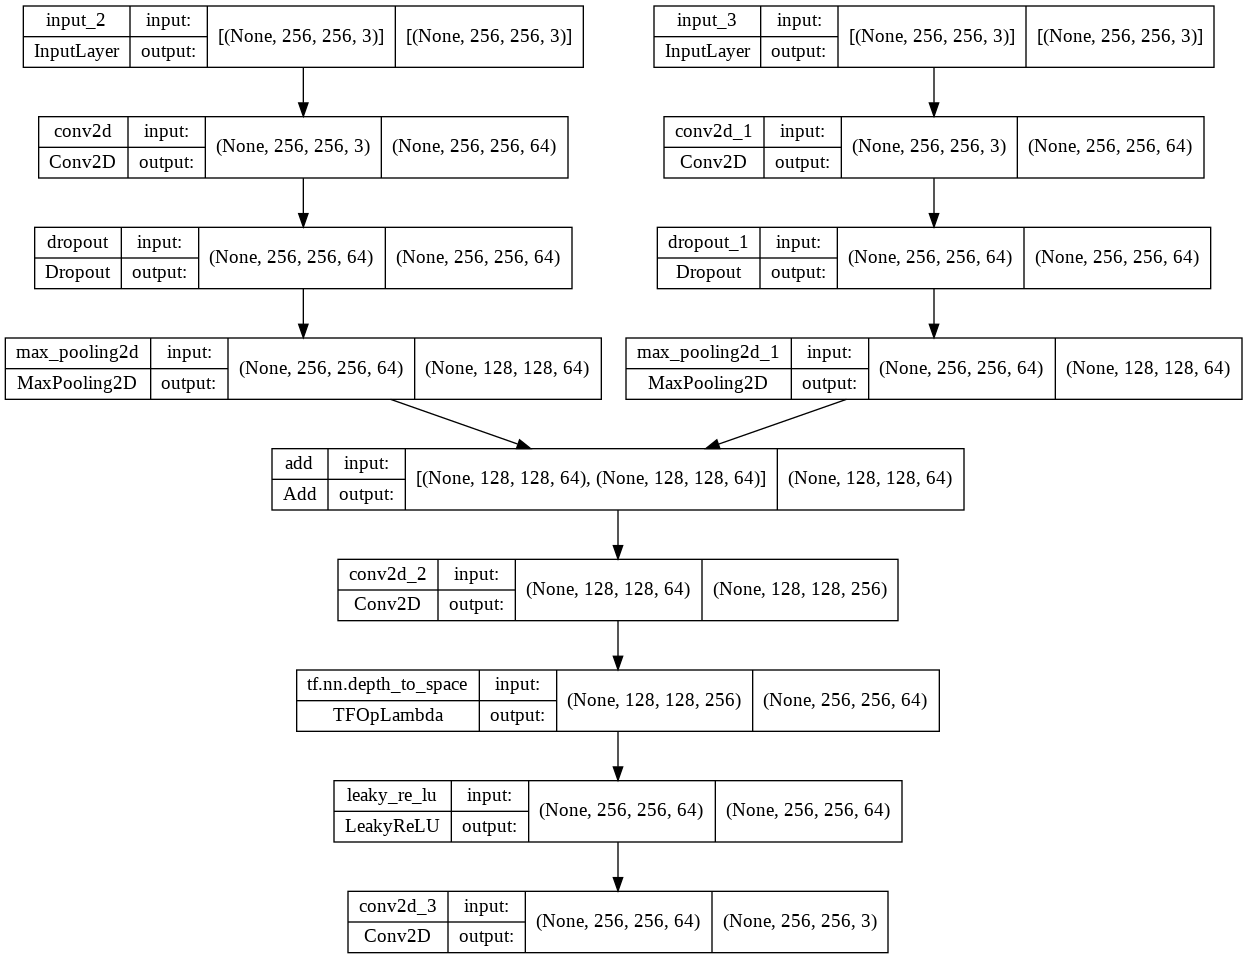

In [ ]:
# left branch of Y network
left_inputs = Input(shape=(256,256,3))
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(1):
    x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  padding='same',
                  activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2
    
# left branch of Y network
right_inputs = Input(shape=(256,256,3))
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(1):
    y = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  padding='same',
                  activation='relu')(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

y = add([x, y])
y=Upsample_block(y)
outputs=Conv2D (3,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(y)

Multi_scale_learning= Model([left_inputs, right_inputs], outputs)
Multi_scale_learning.summary()
Multi_scale_learning.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])
plot_model(Multi_scale_learning, to_file='Multi_scale_learning.png', show_shapes=True)

In [ ]:
Multi_scale_learning.fit([train_low_image, train_low_image],
             train_high_image,
             validation_data=([validation_low_image, validation_low_image], validation_high_image),
             epochs=20,
             batch_size=batch_size)

Epoch 1/20
700/700 [==============================] - 469s 669ms/step - loss: 0.0510 - acc: 0.7155 - val_loss: 0.1528 - val_acc: 0.6647
Epoch 2/20
700/700 [==============================] - 481s 688ms/step - loss: 0.0346 - acc: 0.7594 - val_loss: 0.1420 - val_acc: 0.7857
Epoch 3/20
700/700 [==============================] - 458s 655ms/step - loss: 0.0296 - acc: 0.7866 - val_loss: 0.1426 - val_acc: 0.7849
Epoch 4/20
700/700 [==============================] - 455s 651ms/step - loss: 0.0301 - acc: 0.7970 - val_loss: 0.1535 - val_acc: 0.7292
Epoch 5/20
700/700 [==============================] - 456s 652ms/step - loss: 0.0276 - acc: 0.7972 - val_loss: 0.1393 - val_acc: 0.8321
Epoch 6/20
700/700 [==============================] - 457s 654ms/step - loss: 0.0265 - acc: 0.8106 - val_loss: 0.1362 - val_acc: 0.8700
Epoch 7/20
700/700 [==============================] - 457s 653ms/step - loss: 0.0270 - acc: 0.8095 - val_loss: 0.1352 - val_acc: 0.8212
Epoch 8/20
700/700 [============================

In [ ]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1 / (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(10,20):
    
    predicted = np.clip(Multi_scale_learning.predict([test_low_image[i].reshape(1,SIZE, SIZE,3),test_low_image[i].reshape(1,SIZE, SIZE,3)]),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('PSNR', PSNR(test_high_image[i],predicted))

In [ ]:
#@title Main PROGRAM


In [ ]:
#@title Save and Load Pre-Train Model


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
#torch.save(model, PATH)
#Save pre-train model
torch.save(Multi_scale_learning, '/content/gdrive/MyDrive/DPL301/PRE-TRAIN-MODLE/MSL')

In [2]:
#Load pre-train model
#model = torch.load(PATH)
import torch
model = torch.load('/content/gdrive/MyDrive/DPL301/PRE-TRAIN-MODLE/MSL')

# BONUS: SET UP DATASET FOR TESTING

In [ ]:
#@title Set up Kaggle


In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!mkdir /root/.kaggle

In [5]:
!cp kaggle.json /root/.kaggle

In [6]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d saputrahas/dataset-image-super-resolution

In [7]:
!kaggle datasets download -d adityachandrasekhar/image-super-resolution

 99% 298M/301M [00:02<00:00, 135MB/s]
100% 301M/301M [00:02<00:00, 109MB/s]


In [8]:
!unzip /content/image-super-resolution.zip

Archive:  /content/image-super-resolution.zip
  inflating: dataset/Raw Data/high_res/0.png  
  inflating: dataset/Raw Data/high_res/1.png  
  inflating: dataset/Raw Data/high_res/10.png  
  inflating: dataset/Raw Data/high_res/100.png  
  inflating: dataset/Raw Data/high_res/101.png  
  inflating: dataset/Raw Data/high_res/102.png  
  inflating: dataset/Raw Data/high_res/103.png  
  inflating: dataset/Raw Data/high_res/104.png  
  inflating: dataset/Raw Data/high_res/105.png  
  inflating: dataset/Raw Data/high_res/106.png  
  inflating: dataset/Raw Data/high_res/107.png  
  inflating: dataset/Raw Data/high_res/108.png  
  inflating: dataset/Raw Data/high_res/109.png  
  inflating: dataset/Raw Data/high_res/11.png  
  inflating: dataset/Raw Data/high_res/110.png  
  inflating: dataset/Raw Data/high_res/111.png  
  inflating: dataset/Raw Data/high_res/112.png  
  inflating: dataset/Raw Data/high_res/113.png  
  inflating: dataset/Raw Data/high_res/114.png  
  inflating: dataset/Raw Data

In [ ]:
#@title PSNR


In [9]:
from glob import glob
IMAGE_PATH_HIGH = sorted(glob("/content/dataset/val/high_res/*"))
print('Total test images {}'.format(len(IMAGE_PATH_HIGH)))

Total test images 170


In [10]:
from glob import glob
IMAGE_PATH_LOW = sorted(glob("/content/dataset/val/low_res/*"))
print('Total test images {}'.format(len(IMAGE_PATH_LOW)))

Total test images 170


In [13]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256

low_img = []
#path = '../input/image-super-resolution/dataset/Raw Data/low_res'
path = '/content/dataset/val/low_res'
files = os.listdir(path)
#files = sorted_alphanumeric(files)
files = sorted(files)
for i in tqdm(files):
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 170/170 [00:01<00:00, 151.91it/s]


In [14]:
test_low_image = low_img[100:]
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of test low image:",test_low_image.shape)

Shape of test low image: (70, 256, 256, 3)


In [15]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256

high_img = []
#path = '../input/image-super-resolution/dataset/Raw Data/low_res'
path = '/content/dataset/val/high_res'
files = os.listdir(path)
#files = sorted_alphanumeric(files)
files = sorted(files)
for i in tqdm(files):
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

100%|██████████| 170/170 [00:01<00:00, 99.12it/s]


In [16]:
test_high_image = high_img[100:]
test_high_image = np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))

print("Shape of test high image:",test_high_image.shape)

Shape of test high image: (70, 256, 256, 3)


In [17]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1 / (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [18]:
def plot_images(low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,2)
    plt.title('High Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

PSNR_LIST = []
for i in range(0,70):
    
    predicted = np.clip(model.predict([test_low_image[i].reshape(1,SIZE, SIZE,3),test_low_image[i].reshape(1,SIZE, SIZE,3)]),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],predicted)
    #PSNR_LIST.append(PSNR(test_low_image[i],predicted))
    PSNR_LIST.append(PSNR(test_high_image[i],predicted))
    #print('PSNR', PSNR(test_low_image[i],predicted))
    print('PSNR', PSNR(test_high_image[i],predicted))

Output hidden; open in https://colab.research.google.com to view.

In [19]:
print(PSNR_LIST)

[<tf.Tensor: shape=(), dtype=float32, numpy=20.568436>, <tf.Tensor: shape=(), dtype=float32, numpy=15.095182>, <tf.Tensor: shape=(), dtype=float32, numpy=15.341005>, <tf.Tensor: shape=(), dtype=float32, numpy=16.015636>, <tf.Tensor: shape=(), dtype=float32, numpy=19.186123>, <tf.Tensor: shape=(), dtype=float32, numpy=17.334429>, <tf.Tensor: shape=(), dtype=float32, numpy=24.071682>, <tf.Tensor: shape=(), dtype=float32, numpy=21.199171>, <tf.Tensor: shape=(), dtype=float32, numpy=21.88586>, <tf.Tensor: shape=(), dtype=float32, numpy=17.349838>, <tf.Tensor: shape=(), dtype=float32, numpy=16.057241>, <tf.Tensor: shape=(), dtype=float32, numpy=14.097285>, <tf.Tensor: shape=(), dtype=float32, numpy=17.599237>, <tf.Tensor: shape=(), dtype=float32, numpy=16.770802>, <tf.Tensor: shape=(), dtype=float32, numpy=18.31568>, <tf.Tensor: shape=(), dtype=float32, numpy=26.045498>, <tf.Tensor: shape=(), dtype=float32, numpy=19.60819>, <tf.Tensor: shape=(), dtype=float32, numpy=21.664228>, <tf.Tensor: 

In [20]:
sum = 0
count = 0
for psnr in PSNR_LIST:
  sum = sum + psnr
  count = count + 1

print(sum/count)
print(count)

tf.Tensor(17.920118, shape=(), dtype=float32)
70


In [21]:
A = []
i = 1
for file in PSNR_LIST:
  A.append(i)
  i = i + 1
  

In [22]:
print(A)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


In [23]:
PSNR_03 = []
for numpy in PSNR_LIST:
  PSNR_03.append(float(numpy))

In [24]:
print(PSNR_03)

[20.568435668945312, 15.095182418823242, 15.341005325317383, 16.015636444091797, 19.18612289428711, 17.334428787231445, 24.07168197631836, 21.19917106628418, 21.885860443115234, 17.349838256835938, 16.057241439819336, 14.097285270690918, 17.5992374420166, 16.770801544189453, 18.3156795501709, 26.04549789428711, 19.608190536499023, 21.664228439331055, 15.300408363342285, 16.24477195739746, 11.51118278503418, 23.356971740722656, 15.306661605834961, 20.53460121154785, 17.077606201171875, 15.729241371154785, 19.920909881591797, 26.052942276000977, 18.560827255249023, 15.555234909057617, 21.21790313720703, 18.290035247802734, 18.759443283081055, 15.699539184570312, 15.24844741821289, 16.318645477294922, 20.228403091430664, 18.172100067138672, 15.964761734008789, 14.846389770507812, 16.73674774169922, 17.666793823242188, 17.524150848388672, 17.81881332397461, 19.008106231689453, 14.320737838745117, 11.970442771911621, 16.961219787597656, 19.734468460083008, 16.333251953125, 16.47909164428711

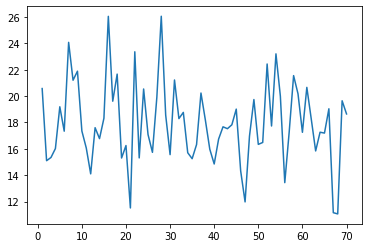

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sns.lineplot(x = A, y = PSNR_03)
plt.show()

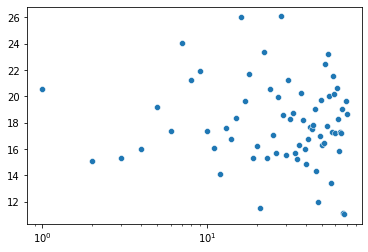

In [26]:
g =sns.scatterplot(x = A, y = PSNR_03)
g.set(xscale="log");

Kết quả PSNR của phương pháp MSL là 17.9. Tuy nhiên như bảng so sánh thì ảnh sao khi xử lí có chất lượng khá tốt chỉ có điều bị tối hơn, nhưng không còn nhiều vết nhiễu, LINK DATASET ĐỂ TEST https://www.kaggle.com/datasets/adityachandrasekhar/image-super-resolution